In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Thesis_work/ML_experiments'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/16LLv0tl9NuELAOpNIA0EW8v8njV1fcVa/Thesis_work/ML_experiments


#Loading libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
#!pip install xgboost
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostRegressor
import sklearn
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.6 MB/s eta 0:00:00


#Method for confusion matrix plot

In [3]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(Y, predicted):
  Y_predicted_classes = []
  for x in predicted:
    if x>=0.5:
        Y_predicted_classes.append(1)

    else:
        Y_predicted_classes.append(0)
#  print(len(Y), len(Y_predicted_classes))

  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(Y, Y_predicted_classes)
  print('Accuracy: %f' % accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(Y, Y_predicted_classes)
  print('Precision: %f' % precision)
  # recall: tp / (tp + fn)
  recall = recall_score(Y, Y_predicted_classes)
  print('Recall: %f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(Y, Y_predicted_classes)
  print('F1 score: %f' % f1)
  cf_matrix = confusion_matrix(Y,Y_predicted_classes)

  group_names = ['True Real','False Fake','False Real','True Fake']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  print(labels.shape)
  print(cf_matrix.shape)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

#Load the dataset


In [4]:
data = pd.read_csv('final_dataset_reviews_clean.csv')
# data.drop(columns=['Unnamed: 0'], inplace = True)
data.head(2)

,Product_ID,Customer_Name,Customer_ID,Date,Rating,Label,Reviews,Sentiment,Features,length,...,content_similarity,ext_score,IRS_score,ARD_Score,RD_Score,Reviews_clean,Sentiment_class,length_clean,words_clean,pid_encoded
0,TE111EL1,itzmr7,6702,2019-11-09,1,0,mil gya hai acha hai aur toota howa b nai hai,Positive,['toota'],45,...,0.051918,0,1,-2.000000,-2.000000,acha tota howa nahi,1.0,19,4,539
1,MI543EL0,Afridi,396,2016-11-21,5,0,aram sy pocket may aa jta hai aur quality b ac...,Positive,"['aram', 'pocket', 'quality']",52,...,0.035987,1,1,0.466667,0.466667,aram pocket jta quality achi,1.0,28,5,336


#TRain and test data

In [5]:
spam_true = data[data['Label']==1]
spam_true=sklearn.utils.shuffle(spam_true, random_state=10)
print(spam_true.shape)
test_true = spam_true[:100]
train_true=spam_true[100:]
spam_false = data[data['Label']==0]
print(spam_false.shape)
spam_false=sklearn.utils.shuffle(spam_false, random_state=10)
test_false = spam_false[:100]
train_false=spam_false[100:]
train_data = pd.concat([train_true,train_false], ignore_index=True, sort=False)
train_data.to_csv('Spam_clean_train'+'.csv', index=False)
test_data = pd.concat([test_true,test_false],ignore_index=True, sort=False)
test_data.to_csv('Spam_clean_test'+'.csv', index=False)

(530, 23)
(3393, 23)


In [6]:
df_train=pd.read_csv('Spam_clean_train.csv');
df_test=pd.read_csv('Spam_clean_test.csv');

In [7]:
df_train.head(10)

,Product_ID,Customer_Name,Customer_ID,Date,Rating,Label,Reviews,Sentiment,Features,length,...,content_similarity,ext_score,IRS_score,ARD_Score,RD_Score,Reviews_clean,Sentiment_class,length_clean,words_clean,pid_encoded
0,VI363HL1,Nasir Arafat Anwar,3953,2017-07-03,5,1,meri wife isse cooking mein istemaal kar rahi ...,Positive,['wife'],73,...,0.043131,1,0,2.250000,2.250000,meri wife coking istemal bohat kam araha,1.0,40,7,589
1,UB622ME1,Hamza,2020,2016-11-14,5,1,bilkul seal pack haalat mein mila aur mein iss...,Negative,"['seal', 'pack', 'haalat', 'masnoaat', 'khush']",71,...,0.053663,1,0,0.098039,0.333333,bilkul seal pack halat mila masnoat khush,0.0,41,7,574
2,VE563HB0,Laraib elahi,2724,2020-01-14,5,1,mene usay kia tu pasnd aya mje bht,Neutral,[],34,...,0.011511,1,1,0.000000,0.000000,mene kia pasnd aya mje bht,0.5,26,6,584
3,MA305FA1,Nabeel Naseer,3863,2018-02-17,3,1,yeh pack haasil karne mein yeh sab se roshan k...,Negative,"['pack', 'haasil', 'roshan', 'khayalat', 'qeem...",261,...,0.073296,0,1,-0.832370,-0.832370,pack hasil karne sab roshan khayalat nahi jais...,0.0,164,28,318
4,TH065EL1,Zeeshan Nakhuda,6143,2019-01-03,4,1,nicer dicer se ab kaam pehlay se bhi zyada asa...,Positive,"['nicer', 'dicer', 'pehlay', 'asan', 'sabziyan...",201,...,0.051853,1,1,0.111111,0.111111,nicer dicer kam pehlay zyada asan hogaya sabzi...,1.0,130,20,550
5,MA305FA1,&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;www.richspath,1,2017-04-04,3,1,kya aap ke paas paiy _ account hai agar aap ap...,Positive,"['paiy', 'account', 'account', 'din', 'ghantay...",176,...,0.033033,0,1,-0.832370,-0.832370,ap pas paiy acount agar ap apne acount har din...,1.0,119,23,318
6,AY536FA1,Farhan Bashir,1707,2020-01-03,3,1,kaafi rough si feel hai iski pehnay mein comfo...,Positive,"['rough', 'feel', 'pehnay', 'comfortable', 'ka...",119,...,0.040672,0,1,-0.208333,-0.208333,rough si fel iski pehnay comfortable liken kap...,1.0,77,13,40
7,TD807EL1,Aamir Naeem,128,2016-10-20,5,1,audio ki quality achi hai aur baki sb chezy b ...,Positive,"['audio', 'quality', 'chezy', 'balance']",57,...,0.036092,1,1,0.114286,0.114286,audio quality achi baki chezy balance,1.0,37,6,537
8,BO626EL1,Bilal,1273,2018-03-10,5,1,bohat achaw microphone hai mehngay walay ki za...,Neutral,"['microphone', 'mehngay', 'zaroorat', 'best']",69,...,0.030766,1,0,-0.470588,1.000000,bohat achaw microphone mehngay walay zarorat n...,0.5,54,8,72
9,LO108HB0,Haji Akber,1981,2017-07-10,3,1,color bilkul natural lagta hai mere hair colo...,Negative,"['color', 'natural', 'hair', 'color', 'match',...",288,...,0.049036,0,1,-0.444444,-0.444444,color bilkul natural lagta mere hair color sah...,0.0,221,39,310


##Features and label

In [8]:
X_train=df_train.drop(columns=['Sentiment_class', 'Label','Sentiment','Date', 'Reviews', 'Reviews_clean', 'Features', 'Product_ID',	'Customer_Name'], axis =1, inplace=False)
X_test=df_test.drop(columns=['Sentiment_class', 'Label','Sentiment','Date', 'Reviews', 'Reviews_clean', 'Features', 'Product_ID',	'Customer_Name'], axis =1, inplace=False)
y_train=df_train['Label']
y_test=df_test['Label']


In [9]:
X_train.head(2)

,Customer_ID,Rating,length,Activity_window,words_counts,pp1,content_similarity,ext_score,IRS_score,ARD_Score,RD_Score,length_clean,words_clean,pid_encoded
0,3953,5,73,734,14,0.0,0.043131,1,0,2.250000,2.250000,40,7,589
1,2020,5,71,1016,14,0.0,0.053663,1,0,0.098039,0.333333,41,7,574


#Resampling Technique RUS(Under sampling)

In [10]:
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_ru, y_train_ru = rus.fit_resample(X_train, y_train)


#Basic Classification Models

In [11]:
X_test.shape

(200, 14)

#Information Gain

In [12]:
from sklearn.feature_selection import mutual_info_classif as MIC
mi_score = MIC(X_train_ru,y_train_ru)
print(mi_score)

[0.11600894 0.02186048 0.01805712 0.09460759 0.04457238 0.
 0.04372406 0.         0.0146147  0.18646919 0.15932426 0.03994759
 0.06090751 0.17776775]


In [13]:
X_train_ru.head(1)

,Customer_ID,Rating,length,Activity_window,words_counts,pp1,content_similarity,ext_score,IRS_score,ARD_Score,RD_Score,length_clean,words_clean,pid_encoded
0,6917,1,20,1338,5,0.0,0.015319,0,0,0.666667,-1.333333,9,2,607


In [14]:
import numpy as np
mi_score_selected_index = np.where(mi_score >0.1)[0]
print(mi_score_selected_index)
X_train_ru = X_train_ru.iloc[:, mi_score_selected_index]
X_test = X_test.iloc[:, mi_score_selected_index]


[ 0  9 10 13]


In [15]:
X_train_ru

,Customer_ID,ARD_Score,RD_Score,pid_encoded
0,6917,0.666667,-1.333333,607
1,6223,-2.638095,-2.638095,529
2,811,-1.500000,-1.500000,614
3,5165,0.000000,0.000000,31
4,5810,0.125000,0.125000,58
...,...,...,...,...
855,6540,0.266667,0.266667,395
856,3663,0.187500,0.187500,502
857,2354,0.312500,0.312500,205
858,5999,0.167630,0.167630,318


##XGBoost

Accuracy: 0.730000
Precision: 0.716981
Recall: 0.760000
F1 score: 0.737864
(2, 2)
(2, 2)


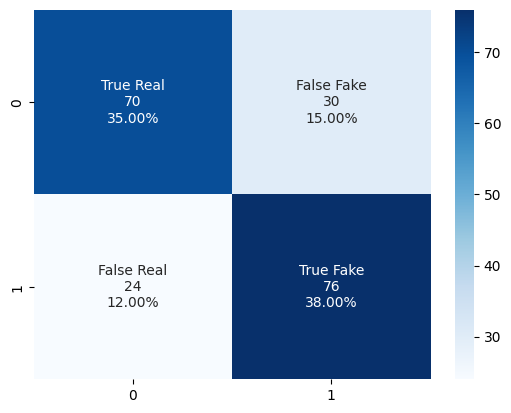

In [16]:

# fit model no training data
model = XGBClassifier(
                      learning_rate=0.01,
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      n_estimators=500,
                      reg_alpha = 0.3,
                      max_depth=10)


#---Without feature selection and parameter tuning------
model.fit(X_train_ru, y_train_ru)
pred_xg = model.predict(X_test)
# evaluate predictions
plot_confusion_matrix(y_test,pred_xg)


##**Gradient Boosting**

              precision    recall  f1-score   support

           0       0.79      0.70      0.74       100
           1       0.73      0.81      0.77       100

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.75       200
weighted avg       0.76      0.76      0.75       200

Accuracy: 0.755000
Precision: 0.729730
Recall: 0.810000
F1 score: 0.767773
(2, 2)
(2, 2)


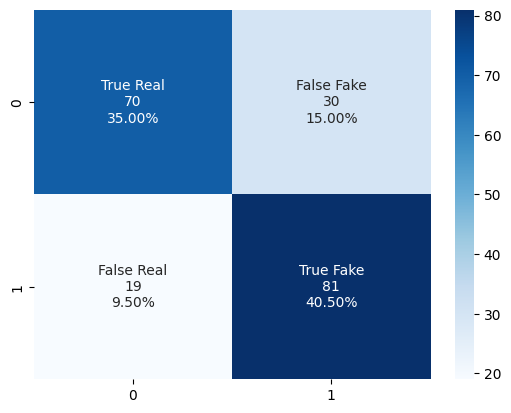

In [17]:
model_gb = GradientBoostingClassifier(random_state=100, n_estimators=500,min_samples_split=10, max_depth=10)

#-------- With Feature selection---------
model_gb.fit(X_train_ru,y_train_ru)
pred_gb = model_gb.predict(X_test)
print(classification_report(y_test, pred_gb))


#-----evaluate results-----
plot_confusion_matrix(y_test,pred_gb)


##Light GBM


[LightGBM] [Info] Number of positive: 430, number of negative: 430
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 860, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Accuracy: 0.750000
Precision: 0.731481
Recall: 0.790000
F1 score: 0.759615
(2, 2)
(2, 2)


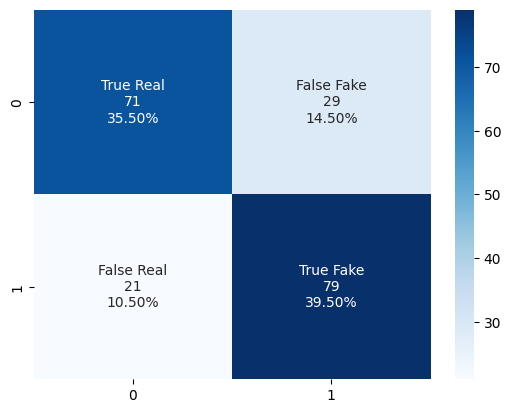

In [18]:
model_lg = lgb.LGBMClassifier()

model_lg.fit(X_train_ru, y_train_ru)
pred_lg = model_lg.predict(X_test)

plot_confusion_matrix(y_test,pred_lg)

##Decision Tree

Accuracy: 0.685000
Precision: 0.676190
Recall: 0.710000
F1 score: 0.692683
(2, 2)
(2, 2)


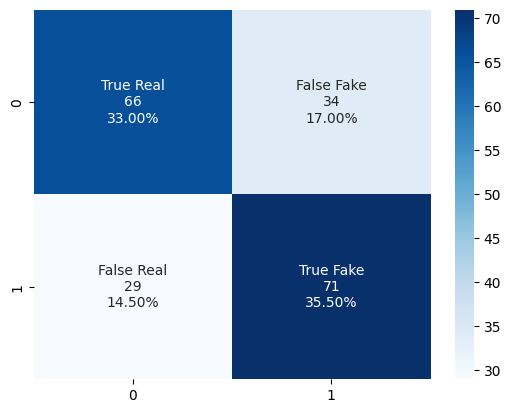

In [19]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_ru, y_train_ru)
pred_dt = model_dt.predict(X_test)
#print('accuracy %s' % accuracy_score(pred_lg, y_test))
#print(classification_report(y_test, pred_lg))
plot_confusion_matrix(y_test,pred_dt)

##feature scaling

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# X_train = MinMaxScaler().fit_transform(X_train)
# X_test = MinMaxScaler().fit_transform(X_test)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

##Naive bayes

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(


Accuracy: 0.550000
Precision: 0.554348
Recall: 0.510000
F1 score: 0.531250
(2, 2)
(2, 2)


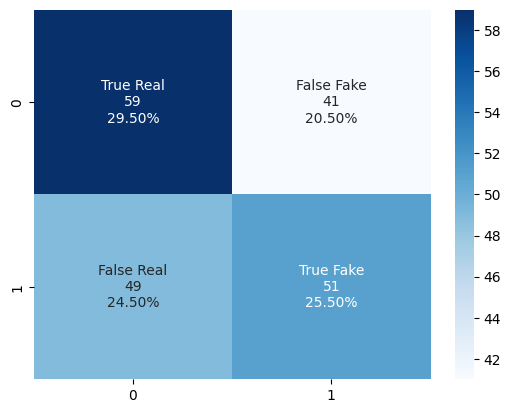

In [21]:
#Bernoulli Navie Bayes Classifier
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train_ru, y_train_ru)
pred_nb = BNB_Classifier.predict(X_test)
# print("\nClassification report for BernoulliNB Classifier %s:\n%s\n" % (BNB_Classifier, metrics.classification_report(y_test, pred_nb)))
plot_confusion_matrix(y_test,pred_nb)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


Accuracy: 0.525000
Precision: 0.522936
Recall: 0.570000
F1 score: 0.545455
(2, 2)
(2, 2)


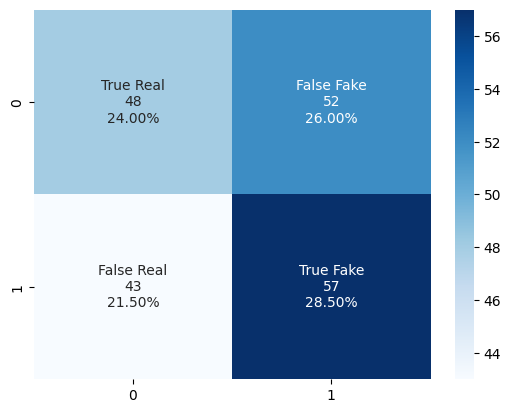

In [22]:
#Bernoulli Navie Bayes Classifier
GNB_Classifier = GaussianNB()
GNB_Classifier.fit(X_train_ru, y_train_ru)
GNB_Predictions =  GNB_Classifier.predict(X_test)
plot_confusion_matrix(y_test,GNB_Predictions)

##Logistic REgression

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Accuracy: 0.540000
Precision: 0.528571
Recall: 0.740000
F1 score: 0.616667
(2, 2)
(2, 2)


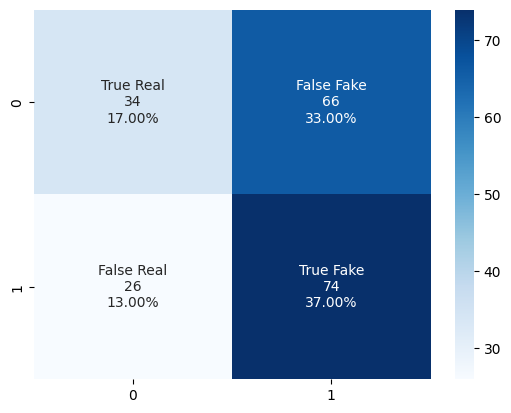

In [23]:
LR_Classifier = LogisticRegression()
LR_Classifier.fit(X_train_ru, y_train_ru)
pred_lr = LR_Classifier.predict(X_test)
plot_confusion_matrix(y_test,pred_lr)

##Support VEctor

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.500000
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
(2, 2)
(2, 2)


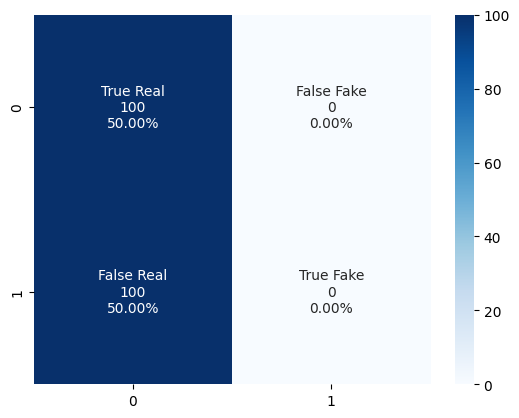

In [24]:
#SVC Classifier
SVC_Classifier = SVC()
SVC_Classifier.fit(X_train_ru, y_train_ru)
pred_svc = SVC_Classifier.predict(X_test)
plot_confusion_matrix(y_test,pred_svc)

##**Random Forest Classifier**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


accuracy 0.495
Accuracy: 0.495000
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
(2, 2)
(2, 2)


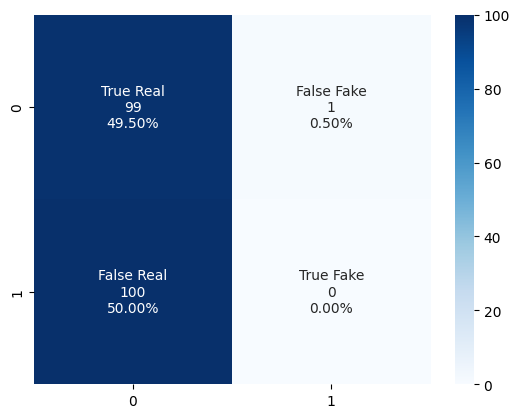

In [25]:

model_rf = RandomForestClassifier(n_estimators=110)
model_rf.fit(X_train_ru,y_train_ru)
pred_rf = model_rf.predict(X_test)
print('accuracy %s' % accuracy_score(pred_rf, y_test))
#print(classification_report(y_test, pred_rf))
plot_confusion_matrix(y_test,pred_rf)

##**Stochastic Gradient Descent**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.550000
Precision: 0.542373
Recall: 0.640000
F1 score: 0.587156
(2, 2)
(2, 2)


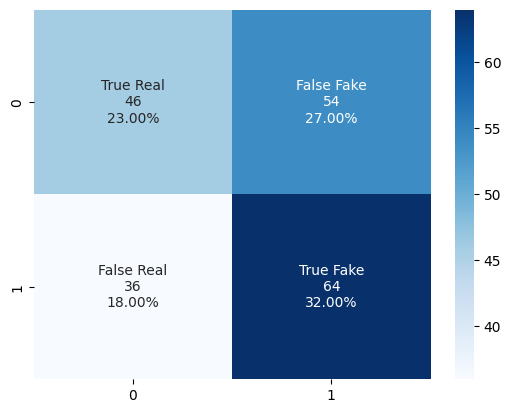

In [26]:

model_sg = SGDClassifier()
model_sg.fit(X_train_ru,y_train_ru)
pred_sg = model_sg.predict(X_test)
plot_confusion_matrix(y_test,pred_sg)

##ANN

In [27]:
X_train_ru.shape[1]

4

In [28]:
from keras import models
from keras import layers
dnn = models.Sequential()
dnn.add(layers.Dense(16, activation = 'relu', input_shape=(X_train_ru.shape[1],)))
dnn.add(layers.Dropout(0.3))
dnn.add(layers.Dense(8, activation = 'relu', input_shape=(X_train_ru.shape[1],)))

dnn.add(layers.Dense(1, activation = 'sigmoid'))

dnn.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = dnn.fit(X_train_ru,
                  y_train_ru,
                    batch_size=40)

dnn.evaluate(X_test,y_test)

7/7 [==============================] - 0s 5ms/step - loss: 0.7003 - accuracy: 0.4700


[0.7002647519111633, 0.4699999988079071]

Accuracy: 0.550000
Precision: 0.542373
Recall: 0.640000
F1 score: 0.587156
(2, 2)
(2, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


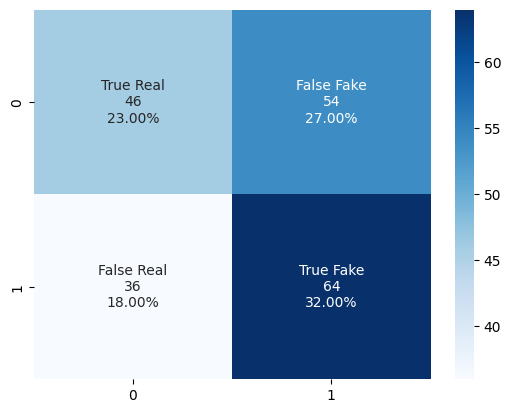

In [29]:
pred_ann = model_sg.predict(X_test)
plot_confusion_matrix(y_test,pred_ann)

#**Best model Accuracy and F-score**

We tested six different models and now, we check which one is the best:

In [30]:
xg_acc = accuracy_score(pred_xg, y_test)
gb_acc = accuracy_score(pred_gb, y_test)
nb_acc = accuracy_score(pred_nb, y_test)
rf_acc = accuracy_score(pred_rf, y_test)
sg_acc = accuracy_score(pred_sg, y_test)
svm_acc = accuracy_score(pred_svc, y_test)
lr_acc = accuracy_score(pred_lr, y_test)
dt_acc = accuracy_score(pred_dt, y_test)
ann_acc = accuracy_score(pred_ann, y_test)
lgb_acc = accuracy_score(pred_lg,y_test)


xg_f1 = f1_score(pred_xg, y_test)
gb_f1 = f1_score(pred_gb, y_test)
nb_f1 = f1_score(pred_nb, y_test)
rf_f1 = f1_score(pred_rf, y_test)
sg_f1 = f1_score(pred_sg, y_test)
svm_f1 = f1_score(pred_svc, y_test)
lr_f1 = f1_score(pred_lr, y_test)
dt_f1 = f1_score(pred_dt, y_test)
ann_f1 = f1_score(pred_ann, y_test)
lgb_f1 = f1_score(pred_lg,y_test)

In [31]:
models = pd.DataFrame({
                      'Model': ['Extreme Gradient', 'Light GBM', 'Naive Bayes', 'Random Forest', 'Gradient Boosting', 'SVM', 'SGD', 'Logistic Regression', 'Decision Tree', 'ANN'],
                      'Accuracy': [xg_acc, lgb_acc, nb_acc, rf_acc, gb_acc, svm_acc, sg_acc, lr_acc, dt_acc, ann_acc],
                      'F-Score': [xg_f1,lgb_f1, nb_f1, rf_f1, gb_f1, svm_f1, sg_f1, lr_f1, dt_f1, ann_f1]
                       })
models.sort_values(by='F-Score', ascending=False, inplace=True)
models.reset_index()

,index,Model,Accuracy,F-Score
0,4,Gradient Boosting,0.755,0.767773
1,1,Light GBM,0.750,0.759615
2,0,Extreme Gradient,0.730,0.737864
3,8,Decision Tree,0.685,0.692683
4,7,Logistic Regression,0.540,0.616667
5,6,SGD,0.550,0.587156
6,9,ANN,0.550,0.587156
7,2,Naive Bayes,0.550,0.531250
8,3,Random Forest,0.495,0.000000
9,5,SVM,0.500,0.000000


In [32]:
models.to_csv("paper/expsettingV_RUS_IG.csv", index=False)

#Grouped confusion matrix

(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)


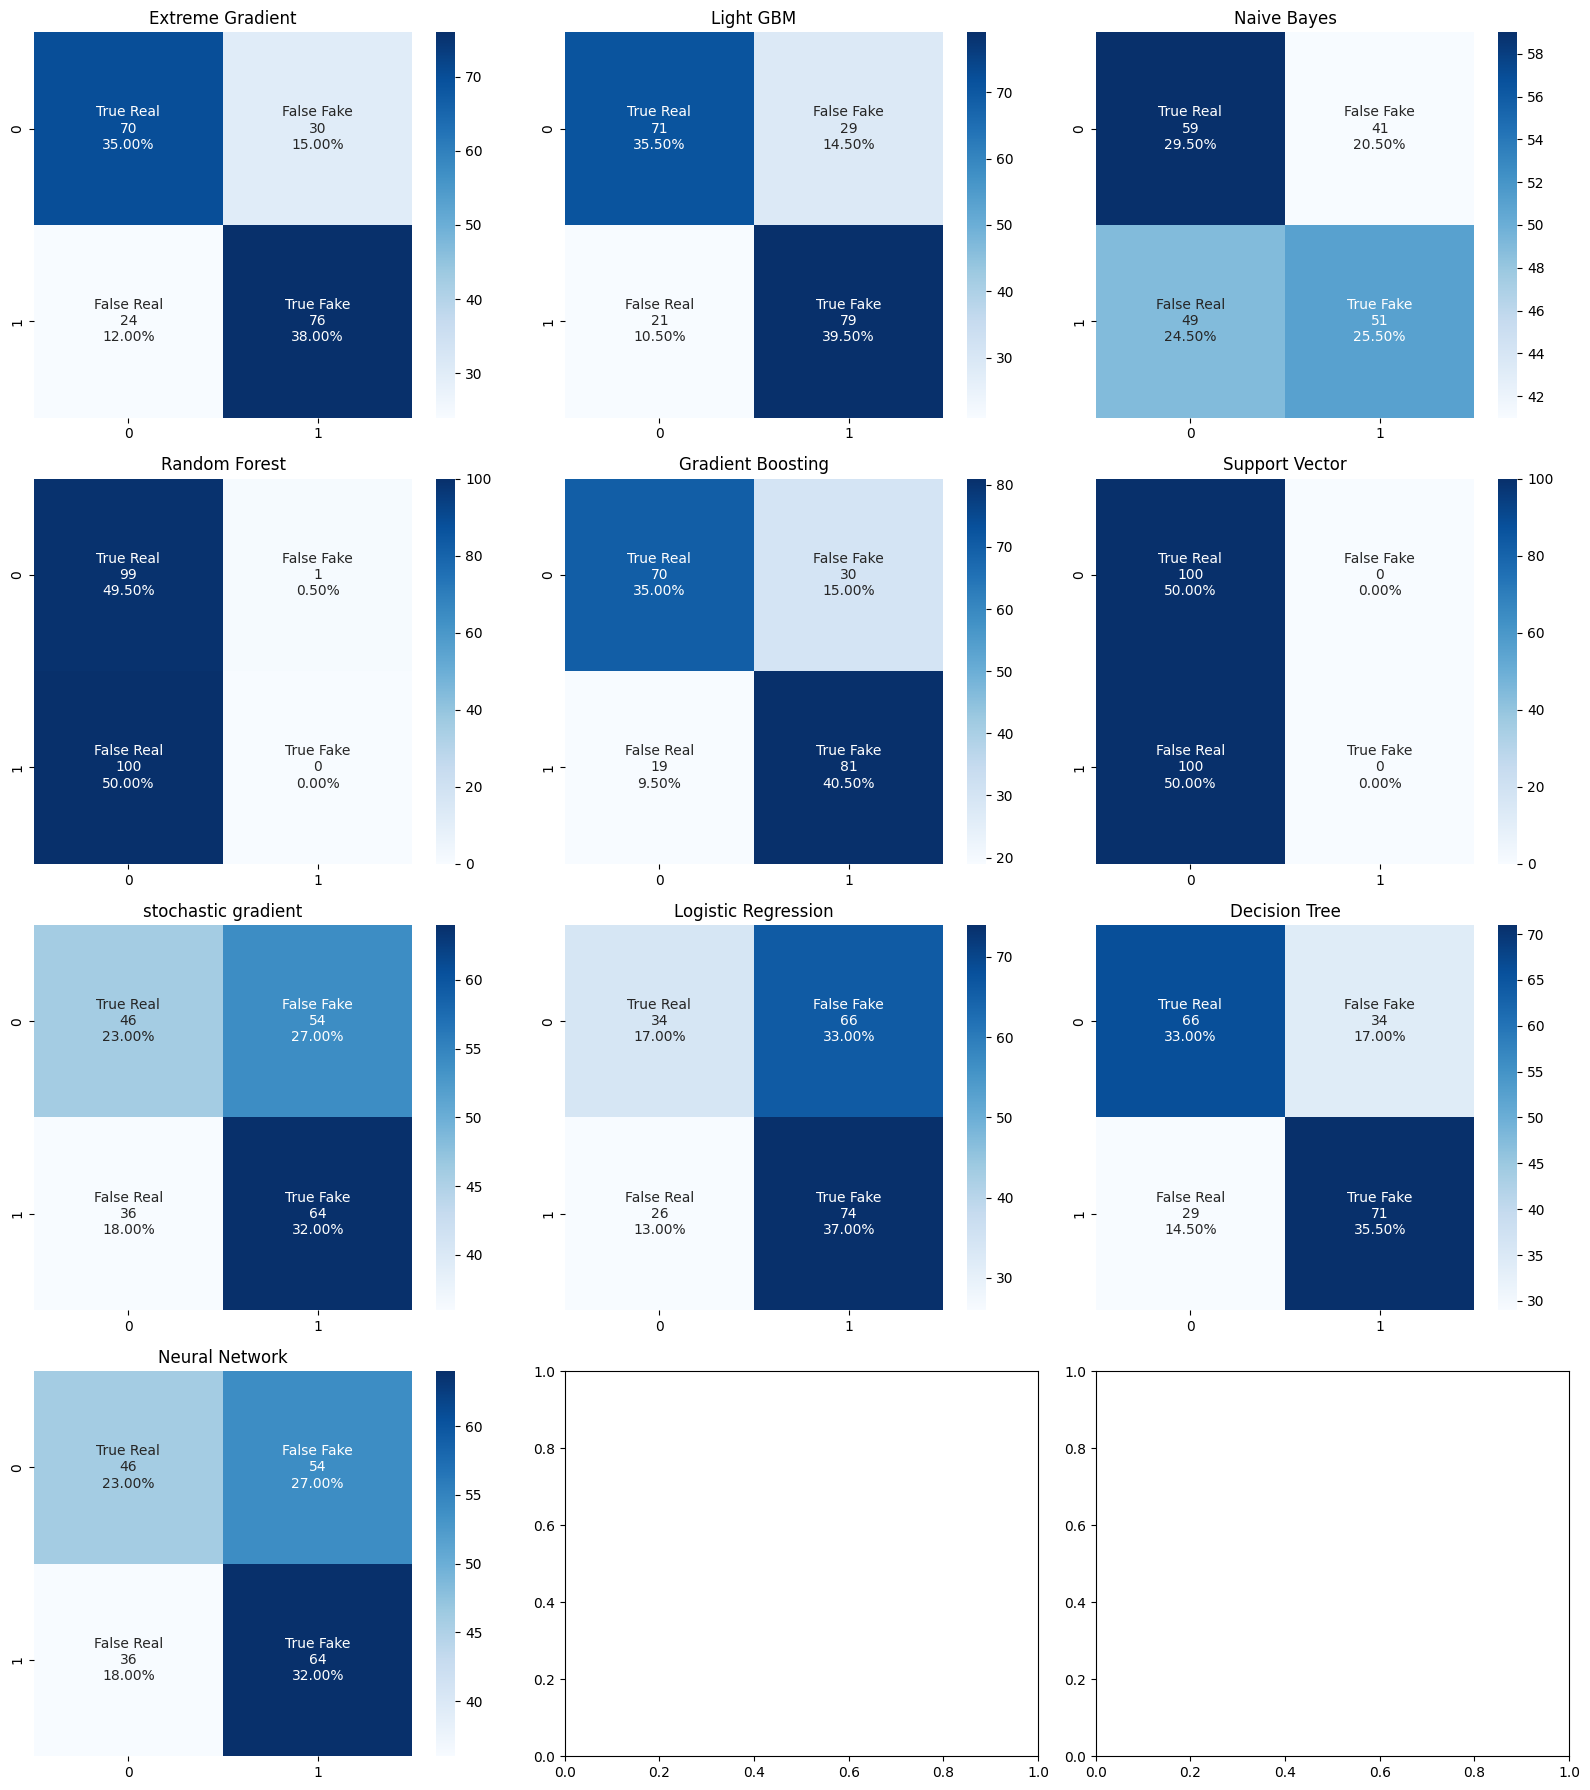

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
fig, axes = plt.subplots(4, 3, figsize=(16, 18))

def plot_grouped_cm(Y, predicted, r,c, model):
  Y_predicted_classes = []
  for x in predicted:
    if x>=0.5:
        Y_predicted_classes.append(1)

    else:
        Y_predicted_classes.append(0)
#  print(len(Y), len(Y_predicted_classes))
  cf_matrix = confusion_matrix(Y,Y_predicted_classes)

  group_names = ['True Real','False Fake','False Real','True Fake']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  print(labels.shape)
  print(cf_matrix.shape)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax =axes[r,c])
  axes[r,c].set_title(model)
xg_acc, lgb_acc, nb_acc, rf_acc, gb_acc, svm_acc, sg_acc, lr_acc, dt_acc, ann_acc
plot_grouped_cm(y_test, pred_xg, 0,0, 'Extreme Gradient')
plot_grouped_cm(y_test, pred_lg, 0,1, 'Light GBM')
plot_grouped_cm(y_test, pred_nb, 0,2, 'Naive Bayes')
plot_grouped_cm(y_test, pred_rf, 1,0, 'Random Forest')
plot_grouped_cm(y_test, pred_gb, 1,1, 'Gradient Boosting')

plot_grouped_cm(y_test, pred_svc, 1,2, 'Support Vector')
plot_grouped_cm(y_test, pred_sg, 2,0, 'stochastic gradient')
plot_grouped_cm(y_test, pred_lr, 2,1, 'Logistic Regression')
plot_grouped_cm(y_test, pred_dt, 2,2, 'Decision Tree')
plot_grouped_cm(y_test, pred_ann, 3,0, 'Neural Network')



fig.tight_layout()
fig.savefig("paper/expsettingV_RUS_IG.png")